# Caecilia data re-analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib

try:
    # if on colab
    from google.colab import drive, files
    drive.mount('/content/drive')

    DRIVEDIR = pathlib.Path('drive/Shareddrives/mmWave Drive')

    !pip install uncertainties
    !pip install scikit-rf
except ModuleNotFoundError:
    # if not on colab
    DRIVEDIR = pathlib.Path('../../../../..')

DATADIR = DRIVEDIR / 'Data'

In [3]:
import copy
import pickle
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
import uncertainties
from scipy.constants import c, pi
from uncertainties import ufloat
from uncertainties import unumpy as unp

In [4]:
from suprtools.fp_theory.geometry import SymmetricCavityGeometry
# from sslab_txz.fp_theory.coupling import CouplingConfig
# from sslab_txz.fp_theory.modes import ScalarModeBasis
from suprtools.plotting import sslab_style
from suprtools.rf import WideScanData, Ringdown, fit_mode, test_a_fit, FabryPerotModeParams, ModeMaskingPolicy

In [5]:
mirror_test_dir = Path('../data')
caecilia_data_dir = mirror_test_dir / 'Caecilia'
cassia_data_dir = mirror_test_dir / 'Cassia'
domitia_data_dir = mirror_test_dir / 'Domitia'
egnatia_data_dir = mirror_test_dir / 'Egnatia'

In [6]:
condense_data_dir = caecilia_data_dir / '20221208-cooldown-segment-scan' / 'data'

In [7]:
condense_datas = [
    WideScanData.from_window(p, network_name=p.stem) for p in sorted(condense_data_dir.glob('sweep*.h5'))
]

In [8]:
cooldown_sweep_fit_params = [
    [
        (90.83705, 4, 4),
        (94.26480, 5, 4),
        (97.69214, 5, 3),
        (101.1194, 4, 3),
        (104.54662, 5, 4),
        (107.97384, 2.5, 4),
    ],
    [
        (90.83750, 4, 4),
        (94.26525, 5, 4),
        (97.69259, 5, 3),
        (101.11985, 4, 3),
        (104.54704, 5, 4),
        (107.97422, 2.5, 4),
    ],
    [
        (90.84682, 2.5, 4),
        (94.27499, 2.5, 4),
        (97.70308, 4, 4),
        (101.13107, 4, 4),
        (104.55901, 4, 4),
        (107.98683, 4, 4),
    ],
    [
        (90.84697, 2.5, 4),
        (94.27518, 4, 4),
        (97.70327, 4, 4),
        (101.13125, 4, 4),
        (104.55918, 4, 4),
        (107.98701, 4, 4),
    ],
]

In [9]:
end_ind = 20
condense_datas_trunc = condense_datas[:end_ind]

In [10]:
all_modes_info = []
for i, mode_series in enumerate(cooldown_sweep_fit_params[:2]):
    series_info = []
    for j, (freq_ghz, span_mhz, n_poles_cmplx) in enumerate(mode_series):
        mode_info = []
        
        print(i, j)
        for condense_data in condense_datas:
            try:
                vf = fit_mode(condense_data.s21, freq_ghz, span_mhz / 1e3, n_poles_cmplx=n_poles_cmplx)
            except RuntimeError:
                mode_info.append({
                    key: (ufloat(np.nan, np.nan), ufloat(np.nan, np.nan))
                    for key in ['pole', 'residue']
                })
                continue

            localized_mode_mask = (unp.std_devs(vf.refined_resonances) < 400e+3)
            nominal_freqs = unp.nominal_values(vf.refined_resonances)
            masked_distances = np.where(
                localized_mode_mask,
                np.abs(nominal_freqs - freq_ghz * 1e+9),
                np.inf,
            )
            mode_ind = np.argmin(masked_distances)

            mode_info.append({
                key: (
                    vf.refined_fit_params[f'{key}s']['real'][mode_ind],
                    vf.refined_fit_params[f'{key}s']['imag'][mode_ind],
                )
                for key in ['pole', 'residue']
            })
        series_info.append(mode_info)
    all_modes_info.append(series_info)

0 0


/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 2.05809429568938e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)
/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 1.9969224112312266e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)
/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__edita

0 1
0 2
0 3
0 4


/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 3.34430926727423e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)
/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 2.1699742718587656e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)
/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__edita

0 5


/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 2.2212461380632067e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)
/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 2.3250752856730854e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)
/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__edi

1 0
1 1
1 2
1 3
1 4
1 5


/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 2.351197309822462e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)
/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__editable__.suprtools-2025.8.14-py3-none-any/suprtools/rf/freqdomain.py:1520: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly.
Hint: the linear system was ill-conditioned (max. condition number was 2.0919710054496271e+18).
  vf.vector_fit(n_poles_real=0, n_poles_cmplx=n_poles_cmplx)
/Users/txz/Dropbox (Personal)/stanford/sslab/suprtools/build/__edit

Indices: x/y polarization; longitudinal index; condense sweep

In [11]:
temps = np.array([
    widescandata.metadata_dict['temperature_still']
    for widescandata in condense_datas
])

In [12]:
caecilia_fsr = 3.42621675e+9

In [13]:
all_modes_data = [
    [
        FabryPerotModeParams(
            [temps],
            [
                single_sweep_info['pole'] + single_sweep_info['residue']
                for single_sweep_info in single_mode_info
            ],
            caecilia_fsr,
        )
        for single_mode_info in single_pol_info
    ]
    for single_pol_info in all_modes_info
]

In [14]:
all_modes_data_ndim = FabryPerotModeParams(
    [['x', 'y'], [26, 27, 28, 29, 30, 31], temps],
    [
        [
            [
                single_sweep_info['pole'] + single_sweep_info['residue']
                for single_sweep_info in single_mode_info
            ]
            for single_mode_info in single_pol_info
        ]
        for single_pol_info in all_modes_info
    ],
    caecilia_fsr,
)

In [15]:
with open('caecilia_condense_mode_info.pickle', 'wb') as f:
    pickle.dump(all_modes_data, f)

In [16]:
with open('caecilia_condense_mode_info.pickle', 'rb') as f:
    all_modes_data = pickle.load(f)

In [17]:
# all_modes_records = {
#     (modeq, pol): all_modes_info[pol_i][mode_i]
#     for mode_i, modeq in enumerate(range(26, 26+6))
#     for pol_i, pol in enumerate((+1, -1))
# }

all_modes_records = [
    [
        [
            single_sweep_info['pole'] + single_sweep_info['residue']
            for single_sweep_info in single_mode_info
        ]
        for single_mode_info in single_pol_info
    ]
    for single_pol_info in all_modes_info
]

In [18]:
# with open('caecilia_condense_mode_recs.pickle', 'wb') as f:
#     pickle.dump(all_modes_records, f)
# with open('caecilia_condense_mode_recs.pickle', 'rb') as f:
#     all_modes_records = pickle.load(f)

In [19]:
with open('caecilia_temps.pickle', 'wb') as f:
    pickle.dump(temps, f)

In [20]:
def weighted_umean(uarr):
    print(min(unp.std_devs(uarr)))
    return np.average(
        uarr,
        weights=unp.std_devs(uarr)**(-2),
    )

In [21]:
def coupling_strength_axs_setup(axs):
    axs[0].set_ylabel(
        r'Residue magnitude $|a|$''\n'r'[$2\pi \times$ Hz]'
    )
    axs[1].set_ylabel(r'$Q$-circle diameter $\frac{2|a|}{\kappa}$')
    axs[2].set_ylabel('Finesse')


def coupling_strength_plot(mode_params, masking_policy, axs, modelabel, **plot_kw):
    mode_info_masked = masking_policy.apply(mode_params)
    
    freq = np.nanmean(mode_info_masked.freqs)
    if not isinstance(freq, uncertainties.core.AffineScalarFunc):
        return
    
    def kwarg_func_factory(with_label):
        def kwarg_func(mode_data, *xcombo):
            if with_label:
                return plot_kw | dict(label=f'{modelabel} @ {freq.n/1e+9:10.6f} GHz')
            else:
                return plot_kw

    mode_info_masked.errorbar_plot(
        mode_info_masked.res_mag,
        ax=axs[0],
        kwarg_func=kwarg_func_factory(with_label=True),
    )
    
    diam_abs = 2 * mode_info_masked.res_mag / mode_info_masked.fwhms
    mode_info_masked.errorbar_plot(
        diam_abs,
        ax=axs[1],
        kwarg_func=kwarg_func_factory(with_label=False),
    )

    finesses = mode_info_masked.finesses
    if not np.all(np.isnan(unp.nominal_values(finesses))):
        mode_info_masked.errorbar_plot(
            finesses,
            ax=axs[2],
            kwarg_func=kwarg_func_factory(with_label=False),
        )

In [22]:
def mask_func(mode_info):
    return (
        np.isnan(unp.nominal_values(mode_info.freqs))
        | (unp.std_devs(mode_info.res_mag) > unp.nominal_values(mode_info.res_mag))
        | (np.arange(len(mode_info.params_arr)) > 20)
    )
masking_policy = ModeMaskingPolicy(mask_func)

Text(0.5, 0, 'Temperature [K]')

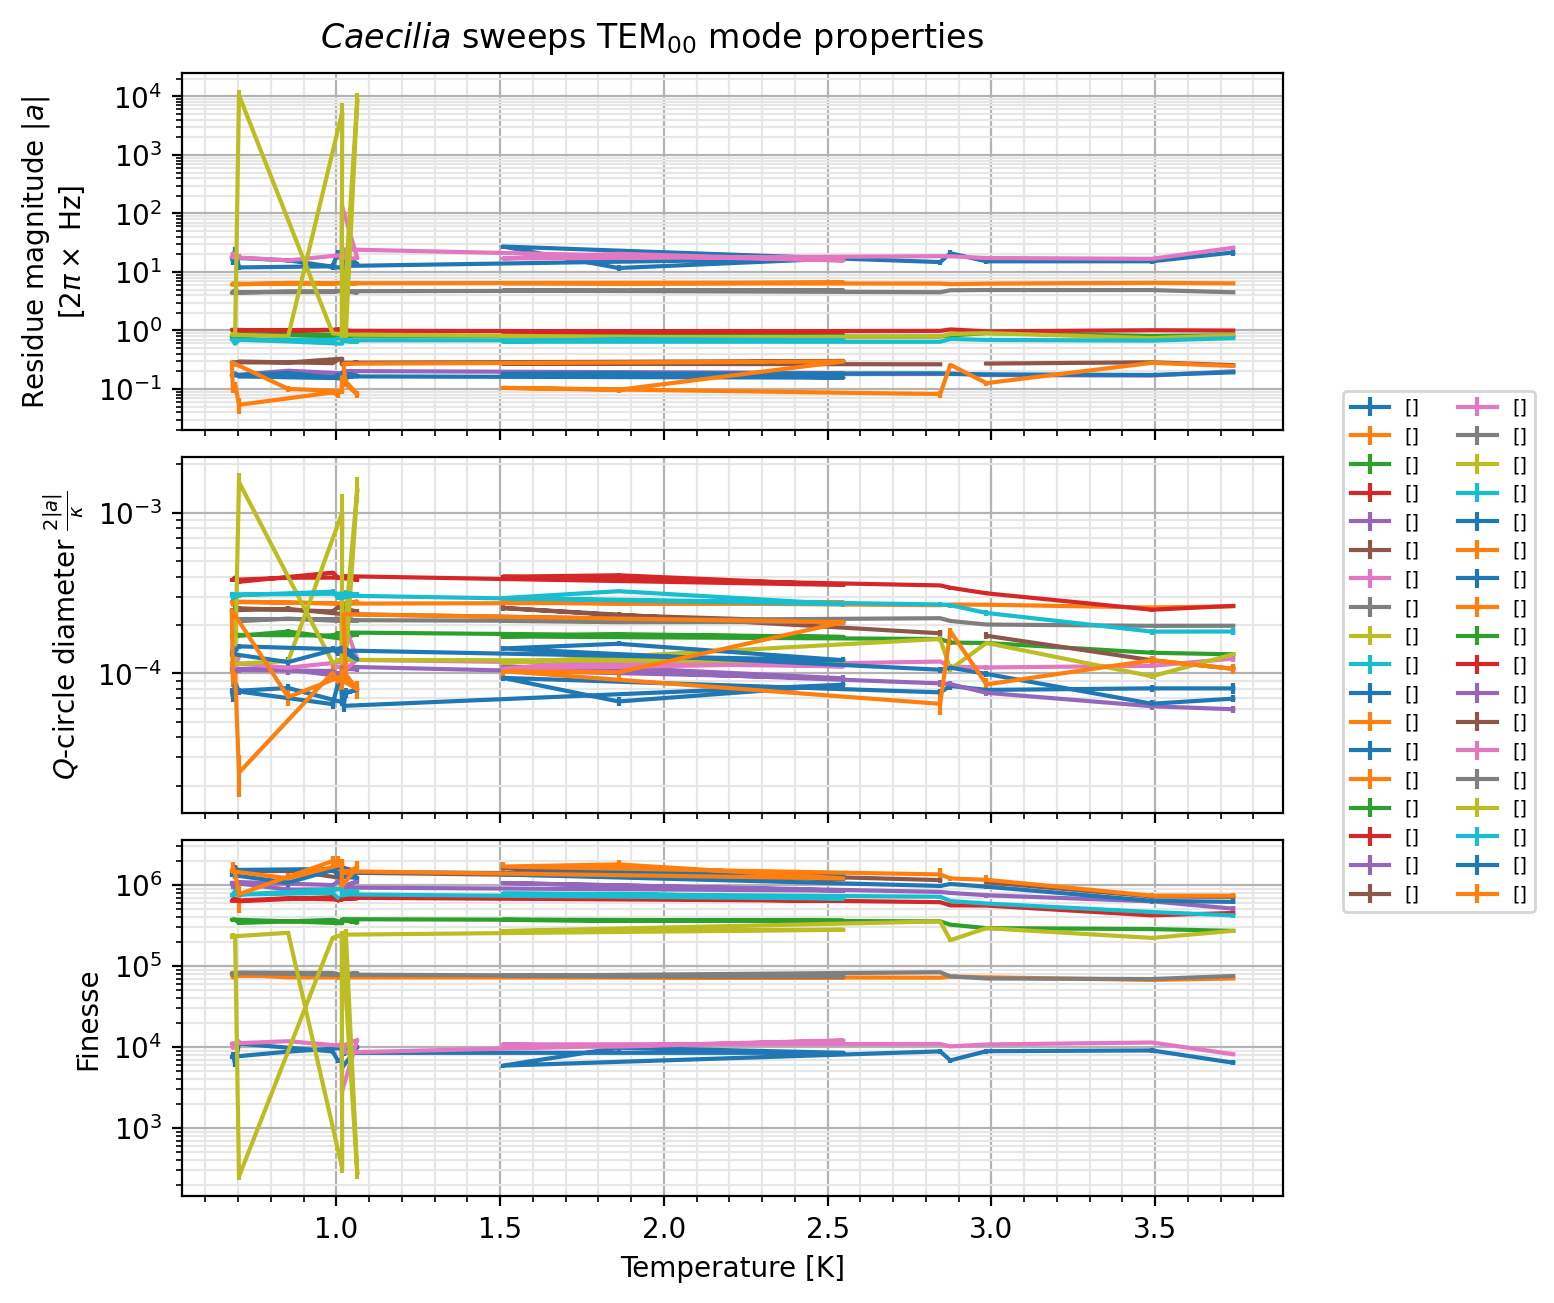

In [23]:
fig, axs = plt.subplots(figsize=(6.4, 6.4), nrows=3, sharex=True, layout='constrained')

for pol, single_pol_data in zip([+1, -1], all_modes_data):
    for mode_i, mode_info in enumerate(single_pol_data):
        marker = '.' if pol == +1 else 'x'
        polstr = 'x' if pol == +1 else 'y'
        
        q = mode_i + 26  # int(freq.n / mode_info.fsr)
        plot_kw = dict(
            marker=marker,
            linestyle='None',
            color=f'C{mode_i}',
        )        
        coupling_strength_plot(
            mode_info,
            masking_policy,
            axs,
            modelabel=f'TEM$_{{{q}, 0, 0, {polstr}}}$',
            **plot_kw,
        )

fig.legend(
    bbox_to_anchor=(1.04, 0.5),
    loc='center left',
    borderaxespad=0,
    ncol=2,
    fontsize='x-small',
)

for ax in axs:
    ax.set_yscale('log')
    sslab_style(ax)

fig.suptitle(r'$\it{Caecilia}$ sweeps TEM$_{00}$ mode properties')
coupling_strength_axs_setup(axs)
axs[-1].set_xlabel('Temperature [K]')

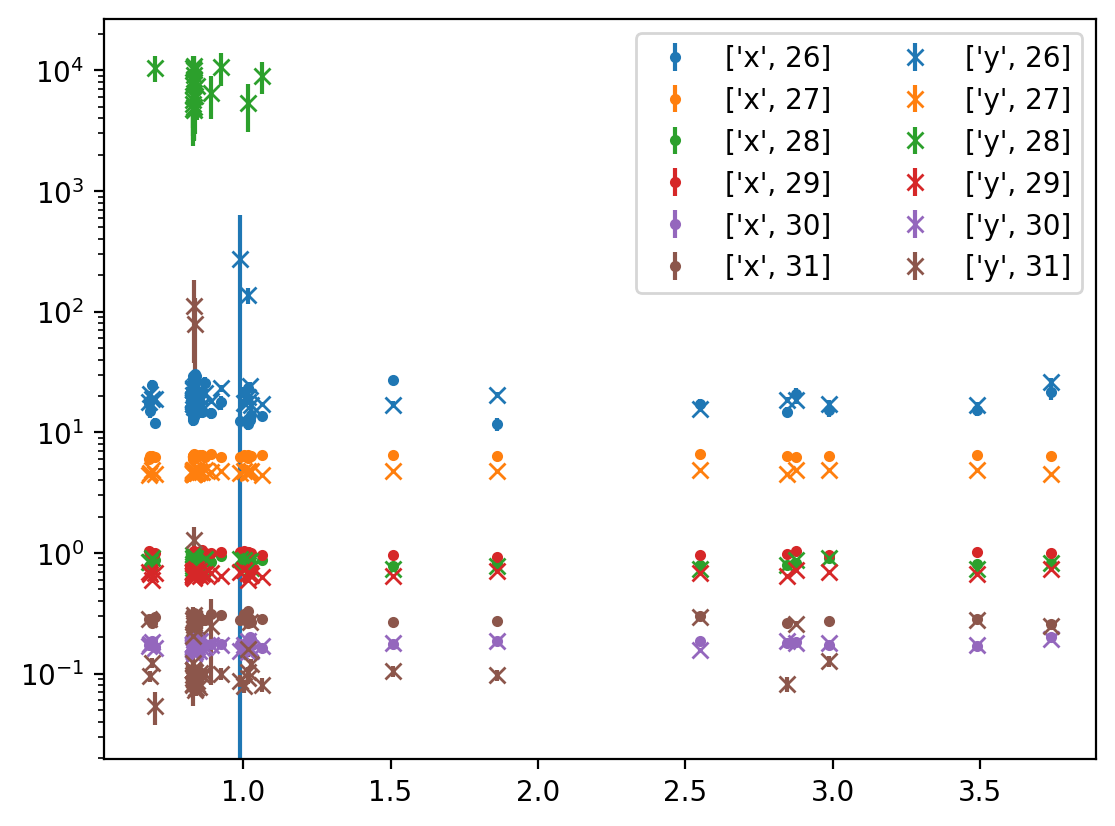

In [24]:
fig, ax = plt.subplots()

all_modes_data_ndim.errorbar_plot(
    all_modes_data_ndim.res_mag,
    ax=ax,
    kwarg_func=(
        lambda mode_data, *xcombo: dict(
            marker=('.' if xcombo[0] == 'x' else 'x'),
            linestyle='None',
            color=f'C{xcombo[1] - 26}',
        )
    ),
)
ax.set_yscale('log')
ax.legend(ncols=2)

Text(0.5, 0, 'Temperature [K]')

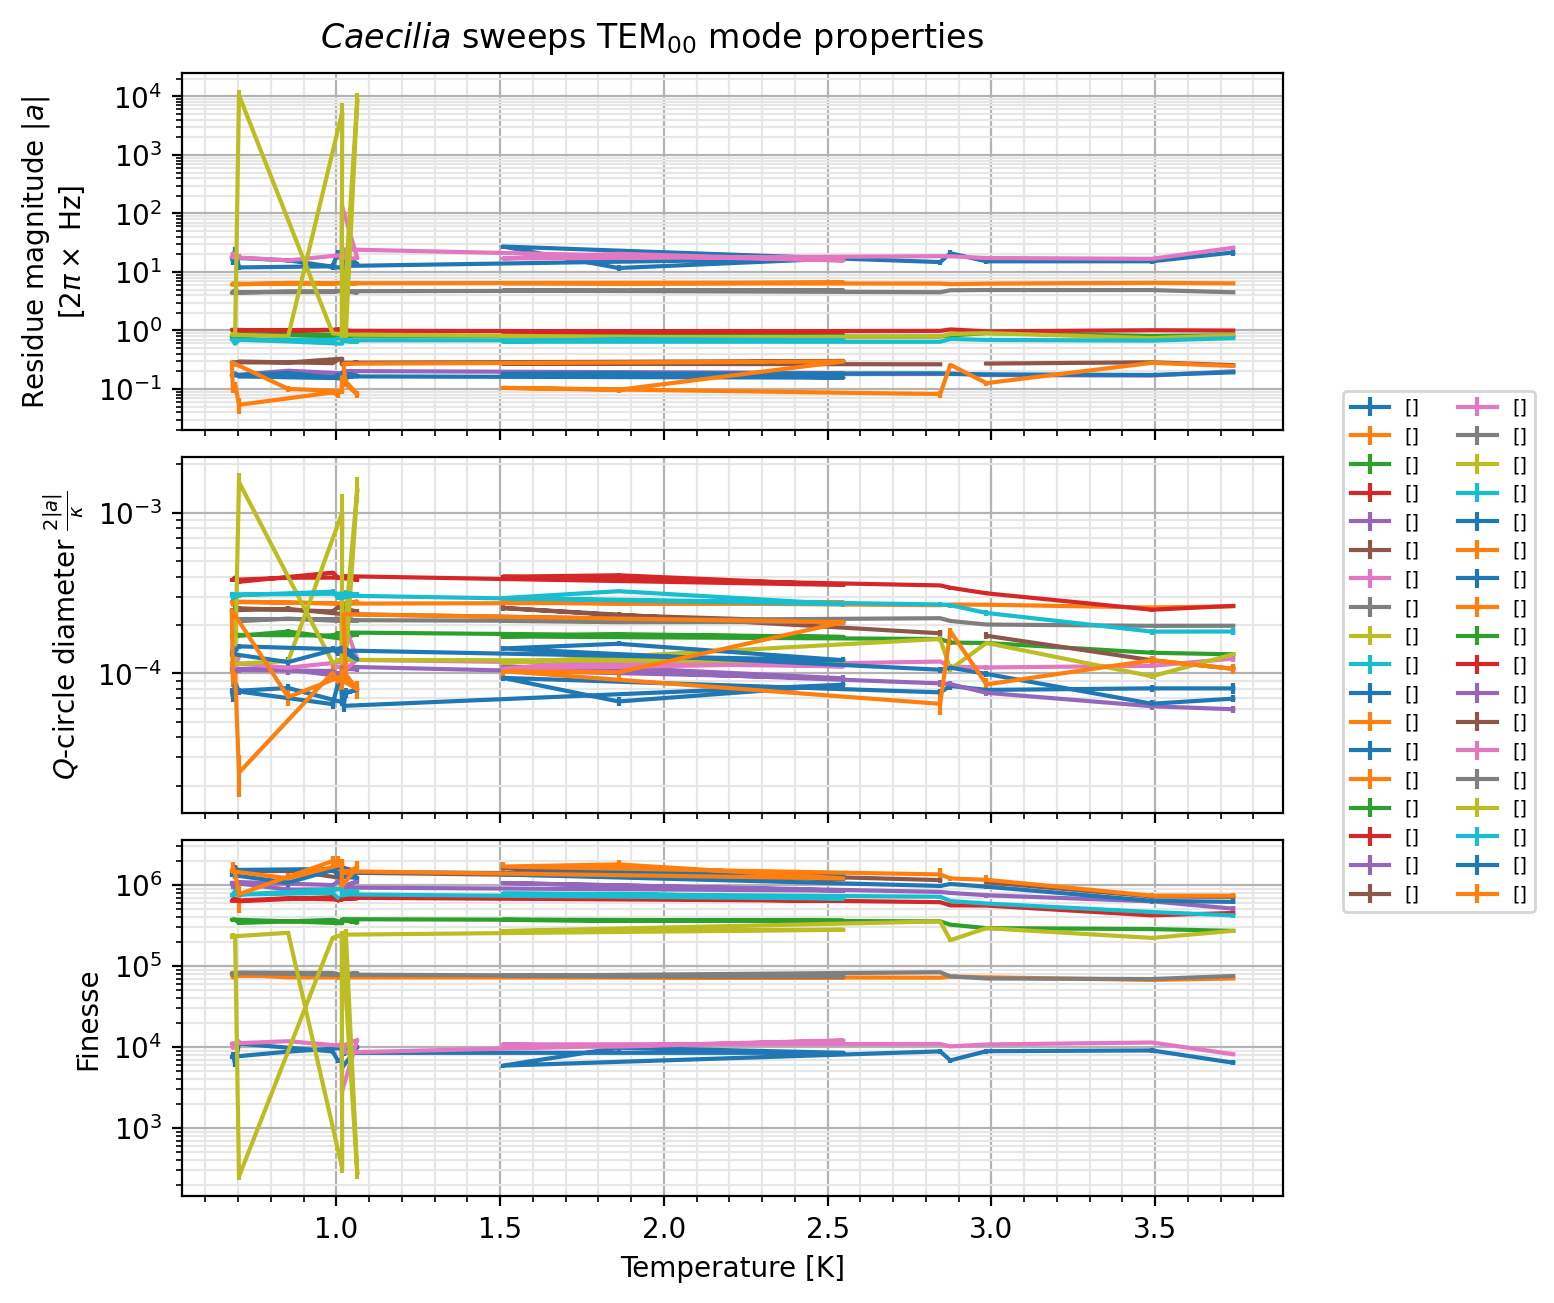

In [25]:
fig, axs = plt.subplots(figsize=(6.4, 6.4), nrows=3, sharex=True, layout='constrained')

for pol, single_pol_data in zip([+1, -1], all_modes_data):
    for mode_i, mode_info in enumerate(single_pol_data):
        marker = '.' if pol == +1 else 'x'
        polstr = 'x' if pol == +1 else 'y'
        
        q = mode_i + 26  # int(freq.n / mode_info.fsr)
        plot_kw = dict(
            marker=marker,
            linestyle='None',
            color=f'C{mode_i}',
        )        
        coupling_strength_plot(
            mode_info,
            masking_policy,
            axs,
            modelabel=f'TEM$_{{{q}, 0, 0, {polstr}}}$',
            **plot_kw,
        )

fig.legend(
    bbox_to_anchor=(1.04, 0.5),
    loc='center left',
    borderaxespad=0,
    ncol=2,
    fontsize='x-small',
)

for ax in axs:
    ax.set_yscale('log')
    sslab_style(ax)

fig.suptitle(r'$\it{Caecilia}$ sweeps TEM$_{00}$ mode properties')
coupling_strength_axs_setup(axs)
axs[-1].set_xlabel('Temperature [K]')

In [26]:
print(
    len(all_modes_info),
    len(all_modes_info[0]),
    len(all_modes_info[0][0]),
    len(all_modes_info[0][0][0]),
)

2 6 60 2


In [27]:
all_modes_info[0][0][0]

{'pole': (-1680622.9455538173+/-122648.07081097735,
  570746316745.5955+/-120604.69312883),
 'residue': (-54.55327692208814+/-15.350598758746953,
  123.90832662723432+/-18.7148483157031)}

In [28]:
import pandas as pd

records = []
for pol_idx, pol_modes in enumerate(all_modes_info):
    pol = 'x' if pol_idx == 0 else 'y'
    for mode_idx, mode_sweeps in enumerate(pol_modes):
        q = mode_idx + 26
        for sweep_idx, sweep_info in enumerate(mode_sweeps):
            def get_n(x):
                if isinstance(x, float) and np.isnan(x):
                    return np.nan
                return x.n

            def get_s(x):
                if isinstance(x, float) and np.isnan(x):
                    return np.nan
                return x.s

            records.append({
                'pol': pol,
                'mode_q': q,
                'sweep_idx': sweep_idx,
                'pole_real_n': get_n(sweep_info['pole'][0]),
                'pole_real_s': get_s(sweep_info['pole'][0]),
                'pole_imag_n': get_n(sweep_info['pole'][1]),
                'pole_imag_s': get_s(sweep_info['pole'][1]),
                'residue_real_n': get_n(sweep_info['residue'][0]),
                'residue_real_s': get_s(sweep_info['residue'][0]),
                'residue_imag_n': get_n(sweep_info['residue'][1]),
                'residue_imag_s': get_s(sweep_info['residue'][1]),
            })

all_modes_df = pd.DataFrame(records)
all_modes_df.set_index(['mode_q', 'pol', 'sweep_idx'], inplace=True)
all_modes_df.sort_index(inplace=True)


In [29]:
all_modes_df

pole_real_n    pole_real_s   pole_imag_n  \
mode_q pol sweep_idx                                              
26     x   0         -1.680623e+06  122648.070811  5.707463e+11   
           1         -1.185215e+06   77925.311676  5.707464e+11   
           2         -1.210216e+06   82319.098582  5.707465e+11   
           3         -1.571049e+06  107342.687580  5.707465e+11   
           4         -1.216818e+06   75425.417852  5.707465e+11   
...                            ...            ...           ...   
31     y   55        -5.955984e+03     391.336978  6.784195e+11   
           56        -5.310932e+03     869.146322  6.784221e+11   
           57        -5.406197e+03     748.154630  6.784221e+11   
           58        -6.435464e+03    1063.728981  6.784221e+11   
           59        -7.433519e+03     423.980414  6.784195e+11   

                        pole_imag_s  residue_real_n  residue_real_s  \
mode_q pol sweep_idx                                                  
26     x   0          120604.693129      -54.553277       15.350599   
           1           80619.408469        0.100937       11.025832   
           2           86770.226301        4.915559       12.082155   
           3           96227.865068      -31.793104       14.655752   
           4           73963.507415       -6.955025        9.379689   
...                             ...             ...             ...   
31     y   55            391.651125        0.144535        0.075103   
           56            868.652040       -0.476863        0.059705   
           57            747.658243       -0.543958        0.059618   
           58           1063.812173       -0.502641        0.066430   
           59            423.724647        0.175985        0.071603   

                      residue_imag_n  residue_imag_s  
mode_q pol sweep_idx                                  
26     x   0              123.908327       18.714848  
           1               95.562728        9.804814  
           2               95.338153       10.612152  
           3              127.270806       14.362420  
           4               92.379228        8.703507  
...                              ...             ...  
31     y   55               1.487388        0.074996  
           56               0.204981        0.059624  
           57               0.266775        0.059577  
           58               0.259701        0.066522  
           59               1.757871        0.071712  

[720 rows x 8 columns]

In [30]:
all_modes_df.to_csv('caecilia_condense_mode_info.csv', na_rep='NaN')

In [31]:
def bar(x):
    if x == 'NaN':
        return ufloat(np.nan, np.nan)
    return uncertainties.ufloat_fromstr(x)

foo = pd.read_csv(
    'caecilia_condense_mode_info.csv',
    index_col=[0, 1, 2],
)

In [32]:
foo

pole_real_n    pole_real_s   pole_imag_n  \
mode_q pol sweep_idx                                              
26     x   0         -1.680623e+06  122648.070811  5.707463e+11   
           1         -1.185215e+06   77925.311676  5.707464e+11   
           2         -1.210216e+06   82319.098582  5.707465e+11   
           3         -1.571049e+06  107342.687580  5.707465e+11   
           4         -1.216818e+06   75425.417852  5.707465e+11   
...                            ...            ...           ...   
31     y   55        -5.955984e+03     391.336978  6.784195e+11   
           56        -5.310932e+03     869.146322  6.784221e+11   
           57        -5.406197e+03     748.154630  6.784221e+11   
           58        -6.435464e+03    1063.728981  6.784221e+11   
           59        -7.433519e+03     423.980414  6.784195e+11   

                        pole_imag_s  residue_real_n  residue_real_s  \
mode_q pol sweep_idx                                                  
26     x   0          120604.693129      -54.553277       15.350599   
           1           80619.408469        0.100937       11.025832   
           2           86770.226301        4.915559       12.082155   
           3           96227.865068      -31.793104       14.655752   
           4           73963.507415       -6.955025        9.379689   
...                             ...             ...             ...   
31     y   55            391.651125        0.144535        0.075103   
           56            868.652040       -0.476863        0.059705   
           57            747.658243       -0.543958        0.059618   
           58           1063.812173       -0.502641        0.066430   
           59            423.724647        0.175985        0.071603   

                      residue_imag_n  residue_imag_s  
mode_q pol sweep_idx                                  
26     x   0              123.908327       18.714848  
           1               95.562728        9.804814  
           2               95.338153       10.612152  
           3              127.270806       14.362420  
           4               92.379228        8.703507  
...                              ...             ...  
31     y   55               1.487388        0.074996  
           56               0.204981        0.059624  
           57               0.266775        0.059577  
           58               0.259701        0.066522  
           59               1.757871        0.071712  

[720 rows x 8 columns]

In [33]:
def row_to_ufloats(row):
    return pd.Series({
        'pole_real': ufloat(row['pole_real_n'], row['pole_real_s']),
        'pole_imag': ufloat(row['pole_imag_n'], row['pole_imag_s']),
        'residue_real': ufloat(row['residue_real_n'], row['residue_real_s']),
        'residue_imag': ufloat(row['residue_imag_n'], row['residue_imag_s']),
    })
bloo = all_modes_df.apply(row_to_ufloats, axis=1)

In [34]:
bloo

pole_real                        pole_imag  \
mode_q pol sweep_idx                                                        
26     x   0          (-1.68+/-0.12)e+06      (5.7074632+/-0.0000012)e+11   
           1          (-1.19+/-0.08)e+06      (5.7074644+/-0.0000008)e+11   
           2          (-1.21+/-0.08)e+06      (5.7074653+/-0.0000009)e+11   
           3          (-1.57+/-0.11)e+06      (5.7074648+/-0.0000010)e+11   
           4          (-1.22+/-0.08)e+06      (5.7074649+/-0.0000007)e+11   
...                                  ...                              ...   
31     y   55           (-6.0+/-0.4)e+03  (6.784194979+/-0.000000004)e+11   
           56           (-5.3+/-0.9)e+03  (6.784220534+/-0.000000009)e+11   
           57           (-5.4+/-0.7)e+03  (6.784220530+/-0.000000007)e+11   
           58           (-6.4+/-1.1)e+03  (6.784220530+/-0.000000011)e+11   
           59           (-7.4+/-0.4)e+03  (6.784194989+/-0.000000004)e+11   

                      residue_real residue_imag  
mode_q pol sweep_idx                             
26     x   0              -55+/-15     124+/-19  
           1                0+/-11      96+/-10  
           2                5+/-12      95+/-11  
           3              -32+/-15     127+/-14  
           4                -7+/-9       92+/-9  
...                            ...          ...  
31     y   55          0.14+/-0.08  1.49+/-0.07  
           56         -0.48+/-0.06  0.20+/-0.06  
           57         -0.54+/-0.06  0.27+/-0.06  
           58         -0.50+/-0.07  0.26+/-0.07  
           59          0.18+/-0.07  1.76+/-0.07  

[720 rows x 4 columns]

In [35]:
all_modes_data

[[<suprtools.rf.modedata.FabryPerotModeParams at 0x186068470>,

KeyError: 'residue_'

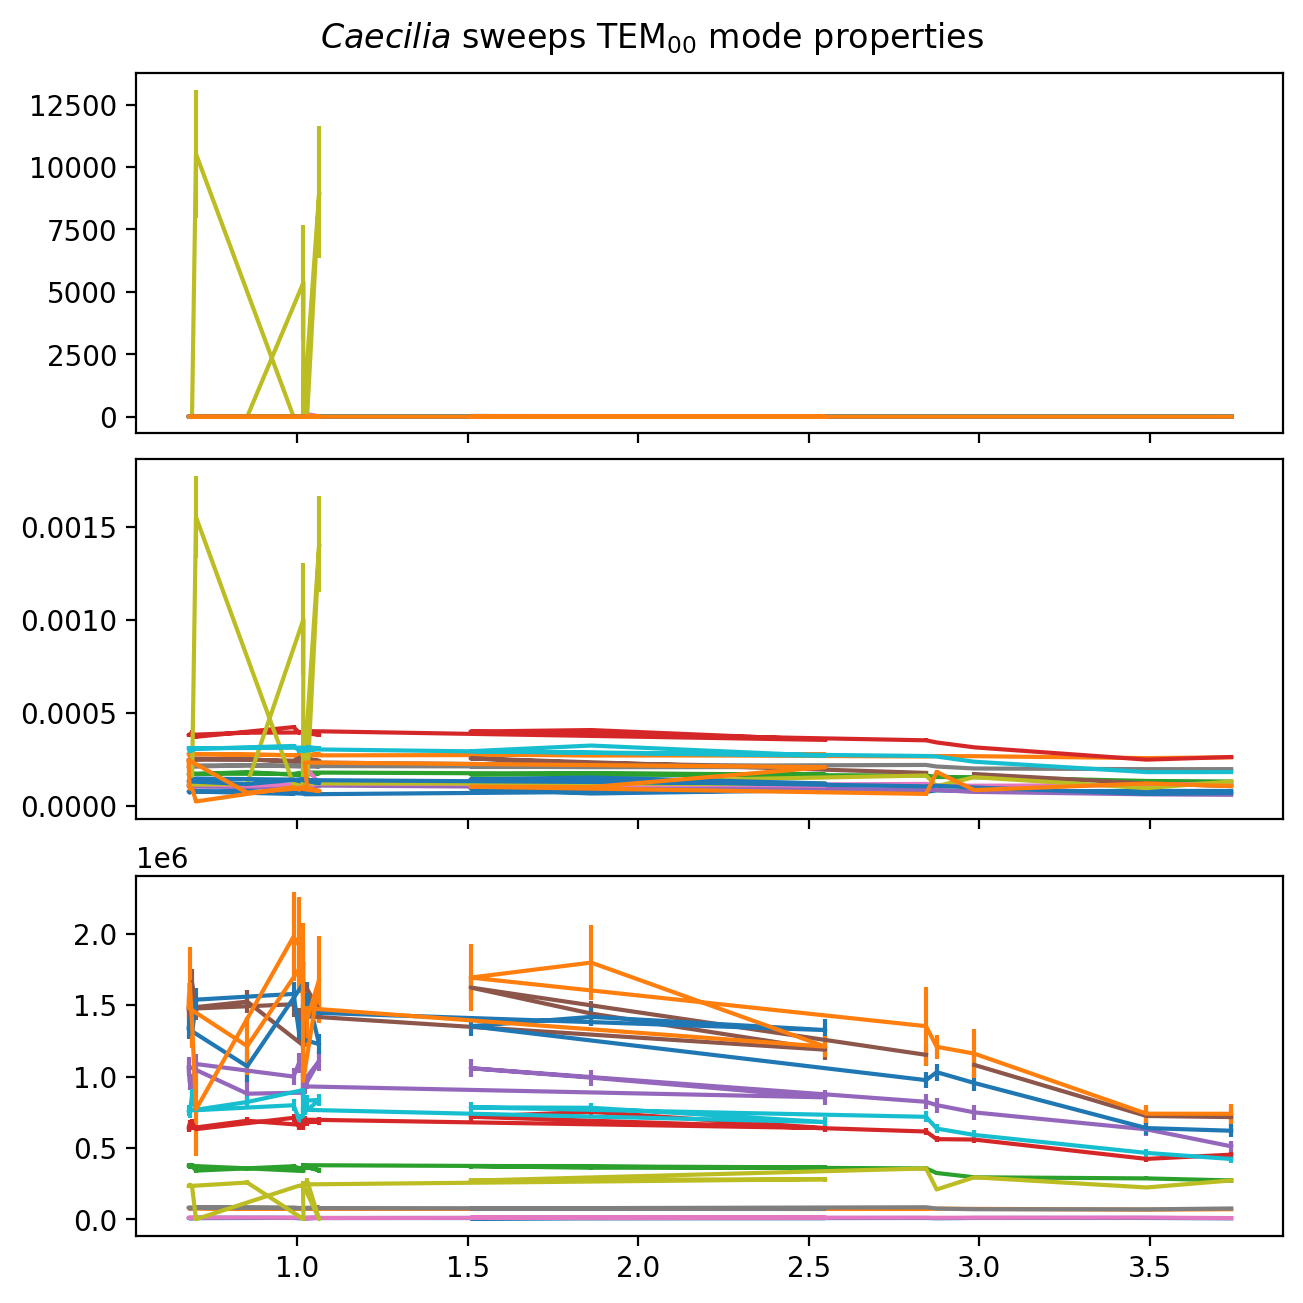

In [36]:
fig, axs = plt.subplots(figsize=(6.4, 6.4), nrows=3, sharex=True, layout='constrained')

fig.suptitle(R'$\it{Caecilia}$ sweeps TEM$_{00}$ mode properties')

for pol_idx in range(2):
    for mode_idx in range(6):
        marker = '.' if pol_idx == 0 else 'x'
        polstr = 'x' if pol_idx == 0 else 'y'
        
        q = mode_idx + 26
        plot_kw = dict(
            marker=marker,
            linestyle='None',
            color=f'C{mode_idx}',
        )
        
        coupling_strength_plot(
            all_modes_data[pol_idx][mode_idx],
            masking_policy,
            axs,
            modelabel=f'TEM$_{{{q}, 0, 0, {polstr}}}$',
            **plot_kw,
        )
axs[0].errorbar(
    temps,
    unp.nominal_values(bloo['residue_']),
    marker='.',
    linestyle='None',
    label='TEM$_{26, 0, 0, x}$',
)